**Cats vs Dogs using Convolutional Neural Network**

<ul>

<li>  Downloads the Cats vs Dogs dataset from cats-and-dogs.zip
<li>  Splits the data into train and validation subdirectories 
<li>  Creates train and validation ImageDataGenerators with data augmentation 
<li>  Creates a convolutional network
<li>  Trains the convolutional network
<li>  Graphs training and validation results
</ul>

In [40]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import numpy as np

print("TF version: ",tf.__version__)
print("Check GPU : ",tf.config.list_physical_devices('GPU'))
print("Check Cuda: ",tf.test.is_built_with_cuda())
print("cwd       : ",os.getcwd())

TF version:  2.6.0
Check GPU :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Check Cuda:  True
cwd       :  C:\Users\Tom\Jupyter\TensorFlow\CNN



**Get the cats and dogs dataset from Microsoft:**


In [3]:
# Data is from https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

# Download data - Don't do th is every time.
# !wget --no-check-certificate \  
# "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
# -O "../../data/cats-and-dogs.zip"

# Unzip data
local_zip = 'd:/data/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('../../data')
zip_ref.close()

**Verify the data:**

In [4]:
source_path = 'd:/data/PetImages'
source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')
print('Dog data is in:',source_path_dogs)
print('Cat data is in:',source_path_cats,'\n')

# Delete non-image files 
#!find "../../data/PetImages/" -type f ! -name "*.jpg" -exec rm {} +
#!find "../../data/PetImages/"  "*.jpg" -exec rm {} +

# Confirm file counts
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

Dog data is in: d:/data/PetImages\Dog
Cat data is in: d:/data/PetImages\Cat 

There are 12501 images of dogs.
There are 12501 images of cats.


**Expected Output:**

```
There are 12501 images of dogs.
There are 12501 images of cats.
```

**Create train and validation directories and split data:**

In [5]:

root_dir = 'd:/data/cats-v-dogs'

# Empty directory to prevent FileExistsError if the function is re-run
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """  

  
  train_dir=os.path.join(root_dir,'training')
  validation_dir=os.path.join(root_dir,'validation')

  mode=0o777  

  os.makedirs(root_dir,mode=0o755)
  os.makedirs(os.path.join(root_dir,'training'),mode)
  os.makedirs(os.path.join(root_dir,'validation'),mode)
    
  os.makedirs(os.path.join(train_dir,'cats'),mode)
  os.makedirs(os.path.join(train_dir,'dogs'),mode)
  os.makedirs(os.path.join(validation_dir,'cats'),mode)
  os.makedirs(os.path.join(validation_dir,'dogs'),mode)

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("File error!")

In [6]:
# Check directory structures

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

d:/data/cats-v-dogs\training
d:/data/cats-v-dogs\validation
d:/data/cats-v-dogs\training\cats
d:/data/cats-v-dogs\training\dogs
d:/data/cats-v-dogs\validation\cats
d:/data/cats-v-dogs\validation\dogs


**Expect:**
```
cats-v-dogs/training
cats-v-dogs/validation
cats-v-dogs/training/cats
cats-v-dogs/training/dogs
cats-v-dogs/validation/cats
cats-v-dogs/validation/dogs
```

**Split training and validation data sets**
<ul>
<li>files are  randomized
<li>zero file lengths are skipped


In [7]:

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    """
    Splits the data into train and test sets
  
    Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
    Returns:
    None
    """
  
    filelist=os.listdir(SOURCE_DIR)
    numfiles=len(filelist)
    filelist=random.sample(filelist,numfiles)
    #print(filelist)

    for filename in filelist[:]:
    #    print ("trying: ",filename)
        if os.path.getsize(os.path.join(SOURCE_DIR,filename))==0:
            print(filename,"is zero length, so ignoring.")
            filelist.remove(filename)
 
    numfiles=len(filelist)            
    
    calc_split= round(SPLIT_SIZE*numfiles)
    
    for filename in filelist[:calc_split]:
        copyfile(os.path.join(SOURCE_DIR, filename), os.path.join(TRAINING_DIR,filename))
       
    for filename in filelist[calc_split:]:
        copyfile(os.path.join(SOURCE_DIR, filename), os.path.join(VALIDATION_DIR,filename))


In [8]:
# Run the split and  validate training and validation datasets

# Define paths
CAT_SOURCE_DIR = "d:/data/PetImages/Cat/"
DOG_SOURCE_DIR = "d:/data/PetImages/Dog/"

TRAINING_DIR = "d:/data/cats-v-dogs/training/"
VALIDATION_DIR = "d:/data/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Check that the number of images matches the expected output

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12501 images
Original dog's directory has 12501 images

There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


**Expected Output:**

```
666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.

Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation
```

**Create data generators with augmentation and target size of 150,150**




In [9]:
# Create Train and Validation Data Generators with Augmentation

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Args:
      TRAINING_DIR (string): directory path containing the training images
      VALIDATION_DIR (string): directory path containing the validation images
    
    Returns:
    train_generator, validation_generator - tuple containing the two generators
    """
    
    target_size=(150,150)

    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=.2,
                                    height_shift_range=.2,
                                    shear_range=.2,
                                    zoom_range=.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

    # Pass in the appropiate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=target_size)

    # Instantiate the ImageDataGenerator class
    validation_datagen = ImageDataGenerator(
                                    rescale=1/255,
                                    rotation_range=0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    shear_range=0,
                                    zoom_range=0,
                                    horizontal_flip=0,
                                    fill_mode=None)

    # Pass in the appropiate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      target_size=target_size)

    return train_generator, validation_generator


In [10]:
# Test generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


**Expected Output:**

```
Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
```


**Define the Convolutional Neural Network Model**

In [11]:

def create_model():

  model = tf.keras.models.Sequential([ 

    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')      
    ])
  
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model


**Create the model**

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [13]:
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=5,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/5
 33/352 [=>............................] - ETA: 2:31 - loss: 0.7216 - accuracy: 0.5260

C:\Users\Tom\anaconda3\envs\TensorflowGPU\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


352/352 [==============================] - 200s 556ms/step - loss: 0.6573 - accuracy: 0.6032 - val_loss: 0.6180 - val_accuracy: 0.6303
Epoch 2/5
352/352 [==============================] - 122s 346ms/step - loss: 0.5997 - accuracy: 0.6742 - val_loss: 0.5967 - val_accuracy: 0.6731
Epoch 3/5
352/352 [==============================] - 119s 339ms/step - loss: 0.5628 - accuracy: 0.7075 - val_loss: 0.4894 - val_accuracy: 0.7595
Epoch 4/5
352/352 [==============================] - 120s 340ms/step - loss: 0.5347 - accuracy: 0.7293 - val_loss: 0.4493 - val_accuracy: 0.7847
Epoch 5/5
352/352 [==============================] - 121s 345ms/step - loss: 0.5125 - accuracy: 0.7467 - val_loss: 0.4561 - val_accuracy: 0.7775


**Check Accuracy and Create graphs**

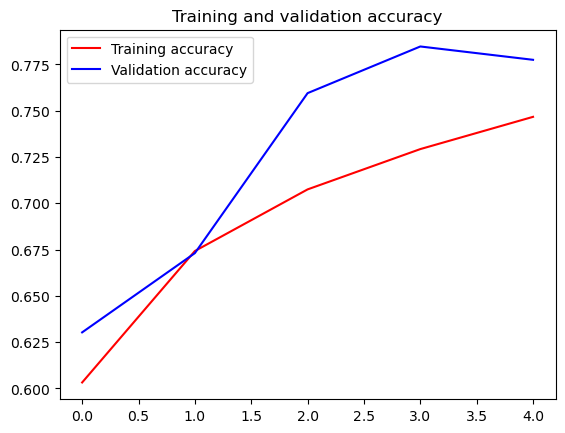

<Figure size 640x480 with 0 Axes>

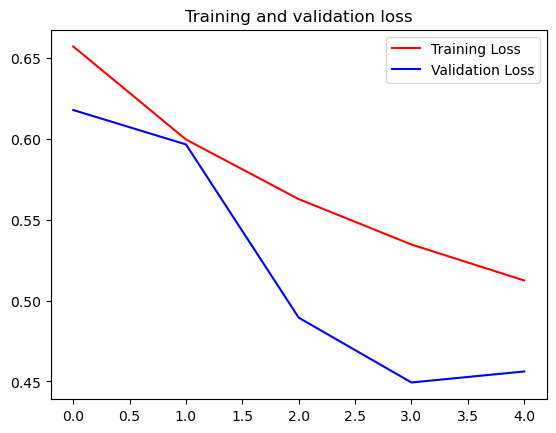

<Figure size 640x480 with 0 Axes>

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

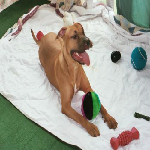

85% certain of dog


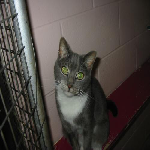

81% certain of cat


In [70]:
filenum=str(random.randint(0,12499))
image1=load_img(os.path.join(DOG_SOURCE_DIR,filenum+'.jpg'), target_size=((150,150)))
image2=load_img(os.path.join(CAT_SOURCE_DIR,'33.jpg'), target_size=((150,150)))
for image in [image1,image2]:
    display(image)
    imgarray=img_to_array(image)
    imgarray/=255.
    imgarray=imgarray.reshape(1,150,150,-1)
    #imgarray=preprocess_input(imgarray)
    odds=float(model.predict(imgarray))
    if odds>.5: prediction='dog'
    else: 
        prediction='cat'
        odds=1-odds
    odds*=100
    print('{:.0f}% certain of {}'.format(odds, prediction))